***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第五章是对支持向量机SVM的系统介绍，阐述支持向量机的核心概念，怎么使用这个强大的模型，以及它是如何工作的。  
这应该是第三次做这方面的内容了，贴出另一个比较全面的SVM进阶博客。
https://blog.csdn.net/v_JULY_v/article/details/7624837
支持向量机（SVM）是个非常强大并且有多种功能的机器学习模型，能够做线性或者非线性的分类，回归，甚至异常值检测。机器学习领域中最为流行的模型之一，是任何学习机器学习的人必备的工具。**SVM特别适合应用于复杂但中小规模数据集的分类问题**。  
本章使用数据为Sklearn中iris数据
### 1. 线性支持向量机分类
教程给出两张图，左图中绿色虚线作为决策边界分类效果不好，红色和紫色线虽然已有数据分类上表现较好，但是因为太靠近样本，这样在引入新的数据时会出现误判。右图中实线为SVM分类器的判定边界，不仅分开了两种类别，而且还尽可能地远离了最靠近的训练数据点。 
**以下的代码为生成对比图的，原教程中没有出现，看看就好**
**注意**
在生成SVM模型的SVC函数中有两个关键参数，kernel和C 
1. σ越大，f越平滑，非线性效能越小，对噪声越不敏感 
 - large σ: High Bias
 - small σ: High Variance
2. C类似于正则化中1/λ的作用。C越大，拟合非线性的能力越强。较小的C会导致更宽的margin，但会有更多的间隔违规。如果SVM模型过拟合，可以尝试通过减小超参数C去调整。
 - large C: High Variance
 - small C: High Bias

- 若使用核函数，一定要对Feature做Feature Scaling(Normalization)。
- 若训练集m太小，但Feature数量n很大，则训练数据不足以拟合复杂的非线性模型，这种情况下只能用linear-kernel（就是fi=xifi=xi）不能用高斯核。
~~~python
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
# 在第三章中已经介绍了iris的数据结构，这里做多个特征分类，所以就获取了data字段的2,3列，就是长度和宽度数据
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]
# 训练一个SVM模型
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)
# 不好的模型，最后生成的是左图
x0=np.linspace(0,5.5,200)
pred_1=5*x0-20
pred_2=x0-1.8
pred_3=0.1*x0+0.5

def plot_svc_decision_boundary(svm_clf,xmin,xmax):
    w=svm_clf.coef_[0]
    b=svm_clf.intercept_[0]
    #在决策边界部分，w0*x0 + w1*x1 + b = 0
    #=>x1=-w0/w1 * x0 - b/w1
    x0=np.linspace(xmin,xmax,200)
    decision_boundary=-w[0]/w[1] * x0 - b/w[1]
    
    margin=1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()
~~~
**现在增加样本，会发现出现在margin外的样本也不会影响判断，因为判定边界是由margin边缘样本确定的，这些确定边界的样本点，被称为“支持向量”**
**注意**SVM 对特征缩放比较敏感，在下图的左图中，垂直的比例要更大于水平的比例，所以最宽的margin接近水平。但对特征缩放后（例如使用Scikit-Learn的StandardScaler），判定边界看起来要好得多
~~~python
Xs=np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys=np.array([0, 0, 1, 1])
svm_clf=SVC(kernel="linear", C=100)
svm_clf.fit(Xs,ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:,0][ys==1],Xs[:,1][ys==1],"bo")
plt.plot(Xs[:,0][ys==0],Xs[:,1][ys==0],"ms")
plot_svc_decision_boundary(svm_clf,0,6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

#使用特征缩放
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaler=scaler.fit_transform(Xs)
svm_clf.fit(X_scaler,ys)
plt.subplot(122)
plt.plot(Xs[:,0][ys==1],Xs[:,1][ys==1],"bo")
plt.plot(Xs[:,0][ys==0],Xs[:,1][ys==0],"ms")
plot_svc_decision_boundary(svm_clf,-2,2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2,2,-2,2])
~~~
#### 软、硬间隔分类
如果我们严格地规定所有的数据都不在margin上，都在正确地两边，称为硬间隔分类，硬间隔分类有两个问题
- 第一，只对线性可分的数据起作用。
- 第二，对异常点敏感。
下图显示了只有一个异常点的鸢尾花数据集：左边的图中很难找到硬间隔，右边的图中判定边界和我们之前在图 5-1 中没有异常点的判定边界非常不一样，它很难一般化。
~~~python
X_outliers=np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers=np.array([0,0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2=SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2,yo2)
plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])
plt.show()
~~~
为了避免这一问题，一般会倾向使用软间隔分类。目的在保持margin尽可能大和避免间隔违规（例如：数据点出现在margin中央或者甚至在错误的一边）之间找到一个良好的平衡。
~~~python
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris=datasets.load_iris()
X=iris["data"][:,(2,3)]
y=(iris["target"]==2).astype(np.float64)
#这里使用pipeline来合并算法流程
svm_clf=Pipeline([
    ("scaler",StandardScaler()),
    ("linear_svc",LinearSVC(C=1,loss="hinge",random_state=42)),    
])
svm_clf.fit(X,y)
svm_clf.predict([[5.5, 1.7]])

scaler=StandardScaler()
svm_clf1= LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
scaled_svm_clf1=Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
])
scaled_svm_clf2=Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf2),
])
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])
~~~
### 2. 非线性支持向量机分类
### 3. SVM回归
### 4. 背后机制


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

In [3]:
# 在第三章中已经介绍了iris的数据结构，这里做多个特征分类，所以就获取了data字段的2,3列，就是长度和宽度数据
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [4]:
# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
# 不好的模型，最后生成的是左图
x0=np.linspace(0,5.5,200)
pred_1=5*x0-20
pred_2=x0-1.8
pred_3=0.1*x0+0.5


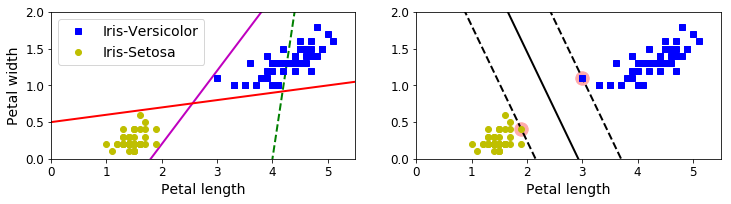

In [14]:
def plot_svc_decision_boundary(svm_clf,xmin,xmax):
    w=svm_clf.coef_[0]
    b=svm_clf.intercept_[0]
    #在决策边界部分，w0*x0 + w1*x1 + b = 0
    #=>x1=-w0/w1 * x0 - b/w1
    x0=np.linspace(xmin,xmax,200)
    decision_boundary=-w[0]/w[1] * x0 - b/w[1]
    
    margin=1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

[-2, 2, -2, 2]

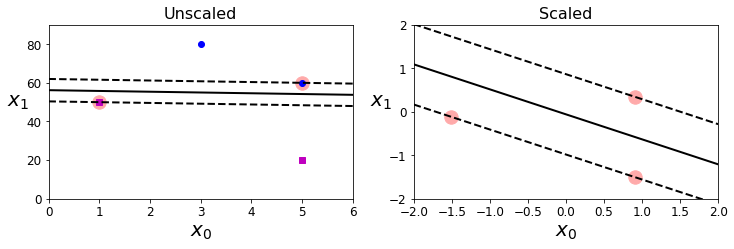

In [20]:
#### **现在增加样本，会发现出现在margin外的样本也不会影响判断，因为判定边界是由margin边缘样本确定的，这些确定边界的样本点，被称为“支持向量”**
#### **注意**SVM 对特征缩放比较敏感，在下图的左图中，垂直的比例要更大于水平的比例，所以最宽的margin接近水平。但对特征缩放后（例如使用Scikit-Learn的StandardScaler），判定边界看起来要好得多
Xs=np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys=np.array([0, 0, 1, 1])
svm_clf=SVC(kernel="linear", C=100)
svm_clf.fit(Xs,ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:,0][ys==1],Xs[:,1][ys==1],"bo")
plt.plot(Xs[:,0][ys==0],Xs[:,1][ys==0],"ms")
plot_svc_decision_boundary(svm_clf,0,6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

#使用特征缩放
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaler=scaler.fit_transform(Xs)
svm_clf.fit(X_scaler,ys)
plt.subplot(122)
plt.plot(Xs[:,0][ys==1],Xs[:,1][ys==1],"bo")
plt.plot(Xs[:,0][ys==0],Xs[:,1][ys==0],"ms")
plot_svc_decision_boundary(svm_clf,-2,2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)

plt.axis([-2,2,-2,2])

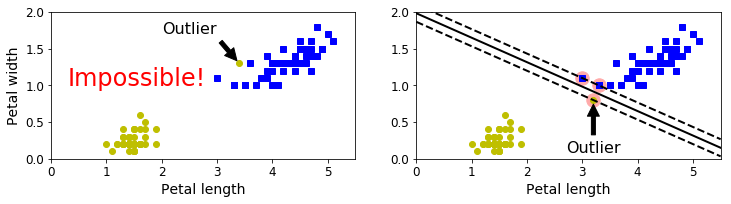

In [23]:
'''
#### 软、硬间隔分类
如果我们严格地规定所有的数据都不在margin上，都在正确地两边，称为硬间隔分类，硬间隔分类有两个问题
- 第一，只对线性可分的数据起作用。
- 第二，对异常点敏感。
下图显示了只有一个异常点的鸢尾花数据集：左边的图中很难找到硬间隔，右边的图中判定边界和我们之前在图 5-1 中没有异常点的判定边界非常不一样，它很难一般化。
'''
X_outliers=np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers=np.array([0,0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2=SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2,yo2)
plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])
plt.show()

In [26]:
'''
为了避免这一问题，一般会倾向使用软间隔分类。目的在保持margin尽可能大和避免间隔违规（例如：数据点出现在margin中央或者甚至在错误的一边）之间找到一个良好的平衡。

'''
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris=datasets.load_iris()
X=iris["data"][:,(2,3)]
y=(iris["target"]==2).astype(np.float64)
#这里使用pipeline来合并算法流程
svm_clf=Pipeline([
    ("scaler",StandardScaler()),
    ("linear_svc",LinearSVC(C=1,loss="hinge",random_state=42)),    
])
svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [27]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [28]:
scaler=StandardScaler()
svm_clf1= LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
scaled_svm_clf1=Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
])
scaled_svm_clf2=Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf2),
])
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [29]:
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 6, 0.8, 2.8]

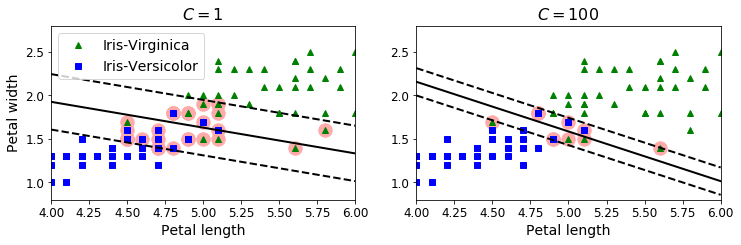

In [31]:
plt.figure(figsize=(12,3.2))

plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])